In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix, roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer  # For MNB
from sklearn.metrics import classification_report

In [2]:
# Load datasets
true_df = pd.read_csv('Datasets/true.csv')
fake_df = pd.read_csv('Datasets/fake.csv')

# Check if 'text' and 'title' columns exist
if 'text' not in true_df.columns or 'text' not in fake_df.columns:
    raise ValueError("Both datasets must have a 'text' column.")

# Add labels (1 for true, 0 for fake)
true_df['label'] = 1
fake_df['label'] = 0

# Combine datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

# Check for missing values
print(df.isnull().sum())

# Drop duplicates
df.drop_duplicates(inplace=True)

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [3]:
# Clean text function
def clean_text(text):
    if pd.isnull(text):
        return ''
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # remove mentions and hashtags
    text = re.sub(r'\d+', '', text)  # remove digits
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = text.lower()  # lowercase
    return text

# Apply cleaning to text and title
df['clean_text'] = df['text'].apply(clean_text)
df['combined_text'] = df['title'].fillna('') + " " + df['clean_text']

In [4]:
# Drop unnecessary columns
df.drop(['date'], axis=1, inplace=True, errors='ignore')

In [5]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['combined_text'])
y = df['label']

In [6]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [7]:
!pip install xgboost
# Model Training without the deprecated parameter
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

Defaulting to user installation because normal site-packages is not writeable


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [8]:
from sklearn.metrics import log_loss
# Predictions
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
train_log_loss = log_loss(y_train, y_train_pred_prob)
test_log_loss = log_loss(y_test, y_test_pred_prob)

print(f"Train Log Loss:{train_log_loss}")
print(f"Test Log Loss:{test_log_loss}")

Train Log Loss:0.00020770568017384125
Test Log Loss:0.010512364781847767


In [9]:
accuracy = accuracy_score(y_test, model.predict(X_test))
precision = precision_score(y_test, model.predict(X_test))
recall = recall_score(y_test, model.predict(X_test))
f1 = f1_score(y_test, model.predict(X_test))
auc_roc = roc_auc_score(y_test, y_test_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.9975
Precision: 0.9967
Recall: 0.9981
F1-Score: 0.9974
AUC-ROC: 0.9998


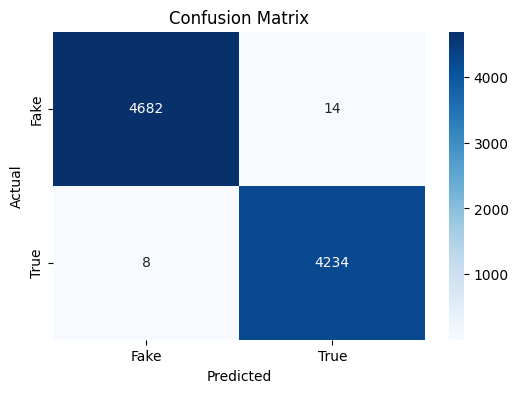

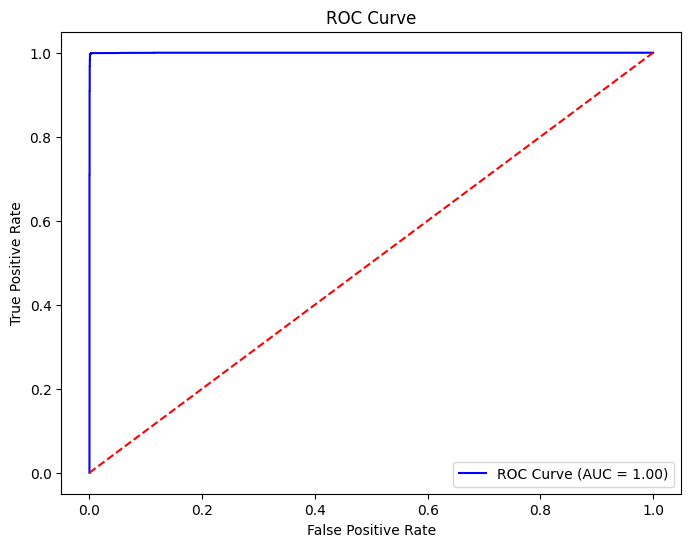

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, model.predict(X_test))
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [11]:
# Display First 10 Predictions
predictions = model.predict(X_test)
predictions_prob = model.predict_proba(X_test)[:, 1]
print("Predicted Labels (First 10):", predictions[:10])
print("Predicted Probabilities (First 10):", predictions_prob[:10])

Predicted Labels (First 10): [1 1 1 0 1 0 0 0 0 1]
Predicted Probabilities (First 10): [9.9999702e-01 9.9996793e-01 9.9998629e-01 1.6842037e-04 9.9999380e-01
 7.1802674e-06 2.1042331e-05 2.1328319e-06 3.5830951e-06 9.9956602e-01]


In [12]:
# Display Class Distribution
print("Class Distribution:")
print(df['label'].value_counts())

Class Distribution:
label
0    23478
1    21211
Name: count, dtype: int64


In [13]:
# Vectorization for Naive Bayes (using CountVectorizer)
count_vectorizer = CountVectorizer(max_features=5000) # Include unigrams and bigrams
X_count = count_vectorizer.fit_transform(df['combined_text'])

In [14]:
# Train-Test Split (same as before)
X_train_count, X_test_count, y_train, y_test = train_test_split(X_count, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
# Multinomial Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_count, y_train)


MultinomialNB()

In [16]:
# Predictions
y_test_pred_nb = nb_model.predict(X_test_count)
y_test_pred_prob_nb = nb_model.predict_proba(X_test_count)[:, 1]

In [17]:
# Evaluation Metrics for Naive Bayes
accuracy_nb = accuracy_score(y_test, y_test_pred_nb)
precision_nb = precision_score(y_test, y_test_pred_nb)
recall_nb = recall_score(y_test, y_test_pred_nb)
f1_nb = f1_score(y_test, y_test_pred_nb)
auc_roc_nb = roc_auc_score(y_test, y_test_pred_prob_nb)
log_loss_nb = log_loss(y_test, y_test_pred_prob_nb)

# Display Metrics for Naive Bayes
print("\n--- Multinomial Naive Bayes Metrics ---")
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1-Score: {f1_nb:.4f}")
print(f"AUC-ROC: {auc_roc_nb:.4f}")
print(f"Log Loss: {log_loss_nb:.4f}")


--- Multinomial Naive Bayes Metrics ---
Accuracy: 0.9541
Precision: 0.9421
Recall: 0.9625
F1-Score: 0.9522
AUC-ROC: 0.9816
Log Loss: 0.8778


In [18]:
# Classification Report for Naive Bayes
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_test_pred_nb))


Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4696
           1       0.94      0.96      0.95      4242

    accuracy                           0.95      8938
   macro avg       0.95      0.95      0.95      8938
weighted avg       0.95      0.95      0.95      8938



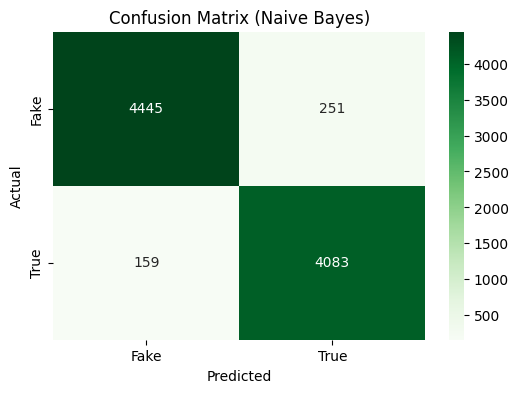

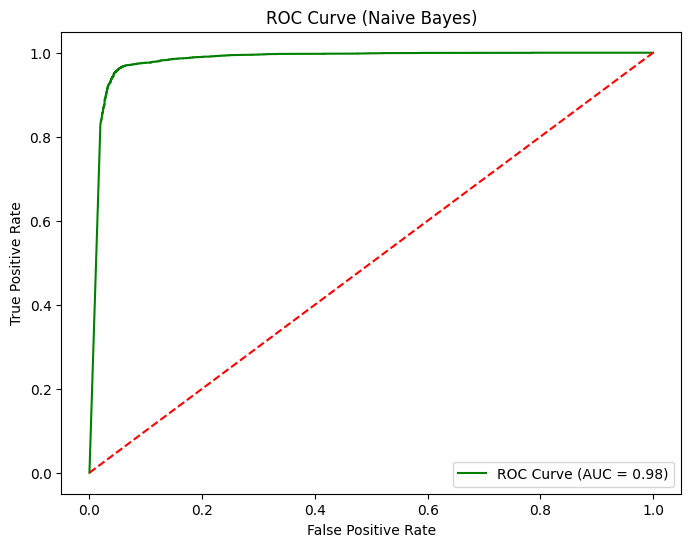

In [19]:
# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_test_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Naive Bayes)')
plt.show()

# ROC Curve for Naive Bayes
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_test_pred_prob_nb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='green', label=f'ROC Curve (AUC = {auc_roc_nb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Naive Bayes)')
plt.legend(loc='lower right')
plt.show()

In [20]:
# Manual Testing for Naive Bayes
def manual_testing_nb(text_input):
    cleaned_text = clean_text(text_input)
    combined_text = count_vectorizer.transform([cleaned_text])
    prediction = nb_model.predict(combined_text)[0]
    prediction_prob = nb_model.predict_proba(combined_text)[0][1]
    result = "True News" if prediction == 1 else "Fake News"
    print(f"\nInput Text: {text_input}")
    print(f"Prediction: {result}")
    print(f"Probability of being True News: {prediction_prob:.4f}")

# Interactive Manual Testing for Naive Bayes
print("\n--- Manual Testing (Naive Bayes) ---")
while True:
    user_input = input("\nEnter a news headline or article (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    manual_testing_nb(user_input)


--- Manual Testing (Naive Bayes) ---


In [21]:
import pickle

# Save the trained Multinomial Naive Bayes model and vectorizer
with open('nb_model.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

with open('count_vectorizer.pkl', 'wb') as f:
    pickle.dump(count_vectorizer, f)
